In [1]:
import os
import logging
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import warnings

from tsaug import AddNoise, TimeWarp

warnings.filterwarnings('ignore')



In [2]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)
rng = random.Random(SEED)
np_rng = np.random.default_rng(SEED)
def seed_worker(worker_id):
    worker_seed = (SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def make_generator():
 g = torch.Generator()
 g.manual_seed(SEED)
 return g

In [3]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    
    Args:
        alpha (float): Weighting factor in range (0,1) to balance positive/negative examples
        gamma (float): Exponent of the modulating factor (1 - p_t)^gamma
    """
    def __init__(self, alpha=0.98, gamma=4.0):
        super(FocalLoss, self).__init__()  # ✅ FIXED: Added double underscores
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predictions from model (before softmax) [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        
        Returns:
            Focal loss value
        """
        # Calculate cross entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Calculate pt (probability of correct class)
        pt = torch.exp(-ce_loss)
        
        # Calculate focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()


In [4]:
class V2GDataset(Dataset):
    """
    V2G Dataset for Federated Learning with data augmentation and balancing.
    Handles participant-based data organization with SMOTE and time-series augmentation.
    """
    
    def __init__(self, csv_path):
        """
        Initialize V2G dataset with preprocessing, augmentation, and balancing.
        
        Args:
            csv_path (str): Path to the CSV file containing V2G data
        """
        # Load and validate data
        self.data = self._load_and_validate_data(csv_path)
        
        # Feature engineering
        self._engineer_features()
        
        # Prepare features and labels
        self._prepare_features_and_labels()
        
        # Data augmentation
        self._augment_data()
        
        # Balance dataset with SMOTE
        self._balance_dataset()
        
        # Ensure minimum samples per participant
        self._ensure_minimum_participant_samples()
        
        # Scale features
        self._scale_features()
        
        # Convert to tensors and create indices
        self._finalize_dataset()
        
        # Print summary
        self._print_summary()
    
    def _load_and_validate_data(self, csv_path):
        """Load CSV and perform initial validation."""
        data = pd.read_csv(csv_path)
        print(f"✓ Dataset loaded: {len(data)} records")
        print(f"✓ Columns: {', '.join(data.columns)}")
        
        # Validate required columns
        required_cols = ['participant_id', 'label', 'battery_capacity_kWh', 
                        'current_charge_kWh', 'discharge_rate_kW', 'energy_requested_kWh']
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Validate and clean labels
        if 'label' not in data.columns:
            raise ValueError("Dataset must contain a 'label' column")
        
        data['label'] = data['label'].astype(str).str.lower().str.strip()
        valid_labels = ['honest', 'adversarial']
        initial_len = len(data)
        data = data[data['label'].isin(valid_labels)]
        
        if data.empty:
            raise ValueError("No valid labels found. Expected 'honest' or 'adversarial'")
        
        if len(data) < initial_len:
            print(f"⚠ Removed {initial_len - len(data)} rows with invalid labels")
        
        # Remove rows with missing labels or critical features
        data = data.dropna(subset=['label', 'participant_id'])
        print(f"✓ Valid records after cleaning: {len(data)}")
        
        return data
    
    def _engineer_features(self):
        """Create time-based and engineered features."""
        # Time features
        if 'timestamp' in self.data.columns:
            self.data['timestamp'] = pd.to_datetime(self.data['timestamp'], errors='coerce')
            self.data['hour'] = self.data['timestamp'].dt.hour
            self.data['day_of_week'] = self.data['timestamp'].dt.dayofweek
            self.data['is_weekend'] = (self.data['day_of_week'] >= 5).astype(int)
            print("✓ Time features extracted from timestamp")
        else:
            self.data['hour'] = 0
            self.data['day_of_week'] = 0
            self.data['is_weekend'] = 0
            print("⚠ No timestamp column found, using default time features")
        
        # Engineered features with safe division
        epsilon = 1e-6
        self.data['charge_discharge_ratio'] = (
            self.data['current_charge_kWh'] / (self.data['discharge_rate_kW'] + epsilon)
        )
        self.data['energy_hour_interaction'] = (
            self.data['energy_requested_kWh'] * self.data['hour']
        )
        self.data['charge_capacity_ratio'] = (
            self.data['current_charge_kWh'] / (self.data['battery_capacity_kWh'] + epsilon)
        )
        self.data['efficiency_estimate'] = (
            self.data['energy_requested_kWh'] / (self.data['discharge_rate_kW'] * 0.25 + epsilon)
        )
        
        print("✓ Engineered features created")
    
    def _prepare_features_and_labels(self):
        """Extract features, labels, and participant IDs."""
        self.feature_cols = [
            'battery_capacity_kWh', 'current_charge_kWh', 'discharge_rate_kW',
            'energy_requested_kWh', 'hour', 'charge_discharge_ratio',
            'energy_hour_interaction', 'charge_capacity_ratio',
            'efficiency_estimate', 'day_of_week', 'is_weekend'
        ]
        
        # Handle missing feature columns
        available_cols = [col for col in self.feature_cols if col in self.data.columns]
        if len(available_cols) < len(self.feature_cols):
            missing = set(self.feature_cols) - set(available_cols)
            print(f"⚠ Missing feature columns: {missing}")
        
        self.features = self.data[available_cols].fillna(0).values
        self.labels = self.data['label'].values
        self.participant_ids = self.data['participant_id'].values
        self.original_indices = np.arange(len(self.data))
        
        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        labels_numeric = self.label_encoder.fit_transform(self.labels)
        
        # Print distribution statistics
        unique_participants = len(np.unique(self.participant_ids))
        honest_count = np.sum(labels_numeric == self.label_encoder.transform(['honest'])[0])
        adversarial_count = len(labels_numeric) - honest_count
        
        print(f"✓ Label classes: {list(self.label_encoder.classes_)}")
        print(f"✓ Data distribution: {honest_count} honest, {adversarial_count} adversarial")
        
        honest_mask = labels_numeric == self.label_encoder.transform(['honest'])[0]
        honest_parts = len(np.unique(self.participant_ids[honest_mask]))
        adversarial_parts = unique_participants - honest_parts
        print(f"✓ Participants: {honest_parts} honest, {adversarial_parts} adversarial")
    
    def _augment_data(self):
        """Apply deterministic data augmentation."""
        np.random.seed(SEED)
        
        try:
            # Try tsaug augmentation
            augmenter = AddNoise(scale=0.1) + TimeWarp(n_speed_change=2)
            
            # Reshape for tsaug (needs 3D: samples x timesteps x features)
            features_3d = self.features.reshape(self.features.shape[0], 1, self.features.shape[1])
            X_aug_3d = augmenter.augment(features_3d)
            X_aug = X_aug_3d.reshape(X_aug_3d.shape[0], X_aug_3d.shape[2])
            
            print("✓ Applied tsaug augmentation (AddNoise + TimeWarp)")
            
        except Exception as e:
            # Fallback to simple augmentation
            print(f"⚠ tsaug failed ({str(e)}), using simple augmentation")
            noise = np_rng.normal(0, 0.1, size=self.features.shape)
            X_aug = self.features + noise
        
        # Additional random scaling
        X_aug = X_aug * np_rng.uniform(0.9, 1.1, size=(X_aug.shape[0], 1))
        y_aug = self.labels.copy()
        
        # Combine original and augmented data
        self.features = np.vstack([self.features, X_aug])
        self.labels = np.concatenate([self.labels, y_aug])
        self.participant_ids = np.concatenate([self.participant_ids, self.participant_ids])
        self.original_indices = np.concatenate([self.original_indices, self.original_indices])
        
        print(f"✓ Augmented dataset: {len(self.features)} total records")
    
    def _balance_dataset(self):
        """Balance dataset using SMOTE."""
        # Check if balancing is needed
        unique_labels, counts = np.unique(self.labels, return_counts=True)
        if len(unique_labels) < 2:
            print("⚠ Only one class present, skipping SMOTE")
            self.labels = self.label_encoder.transform(self.labels)
            return
        
        # Determine appropriate k_neighbors
        min_class_count = min(counts)
        k_neighbors = min(3, min_class_count - 1) if min_class_count > 1 else 1
        
        if k_neighbors < 1:
            print("⚠ Insufficient samples for SMOTE, skipping")
            self.labels = self.label_encoder.transform(self.labels)
            return
        
        try:
            smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=SEED)
            self.features, self.labels = smote.fit_resample(self.features, self.labels)
            print(f"✓ SMOTE applied: {len(self.features)} balanced records")
        except Exception as e:
            print(f"⚠ SMOTE failed ({str(e)}), proceeding without balancing")
        
        # Encode labels to numeric
        self.labels = self.label_encoder.transform(self.labels)
    
    def _ensure_minimum_participant_samples(self, min_samples=10):
        """Ensure each participant has at least min_samples records."""
        unique_pids = np.unique(self.participant_ids)
        
        for pid in unique_pids:
            idx = np.where(self.participant_ids == pid)[0]
            
            if len(idx) >= min_samples:
                continue
            
            num_needed = min_samples - len(idx)
            
            # Check if we have multiple classes for this participant
            unique_labels = np.unique(self.labels[idx])
            
            if len(unique_labels) > 1 and len(idx) > 1:
                # Use SMOTE if multiple classes
                try:
                    k = min(1, len(idx) - 1)
                    smote = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=SEED)
                    extra_samples, extra_labels = smote.fit_resample(
                        self.features[idx], self.labels[idx]
                    )
                    extra_samples = extra_samples[-num_needed:]
                    extra_labels = extra_labels[-num_needed:]
                except:
                    # Fallback to duplication
                    repeat_idx = np.random.choice(idx, size=num_needed, replace=True)
                    extra_samples = self.features[repeat_idx]
                    extra_labels = self.labels[repeat_idx]
            else:
                # Duplicate existing samples
                if len(idx) > 0:
                    repeat_idx = np.random.choice(idx, size=num_needed, replace=True)
                    extra_samples = self.features[repeat_idx]
                    extra_labels = self.labels[repeat_idx]
                else:
                    continue
            
            # Add extra samples
            self.features = np.vstack([self.features, extra_samples])
            self.labels = np.concatenate([self.labels, extra_labels])
            self.participant_ids = np.concatenate([
                self.participant_ids, 
                np.array([pid] * len(extra_samples))
            ])
            
            src_idx = idx[0] if len(idx) > 0 else 0
            self.original_indices = np.concatenate([
                self.original_indices,
                np.array([self.original_indices[src_idx]] * len(extra_samples))
            ])
        
        print(f"✓ Ensured minimum {min_samples} samples per participant")
    
    def _scale_features(self):
        """Standardize features using StandardScaler."""
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
        print("✓ Features scaled (StandardScaler)")
    
    def _finalize_dataset(self):
        """Convert to tensors and create participant indices mapping."""
        self.num_features = self.features.shape[1]
        self.num_classes = len(self.label_encoder.classes_)  # FIXED: was self.label
        
        # Convert to PyTorch tensors
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        
        # Create participant indices mapping
        self.participant_indices = defaultdict(list)
        for idx, pid in enumerate(self.participant_ids):
            self.participant_indices[pid].append(idx)
        
        print("✓ Converted to PyTorch tensors")
    
    def _print_summary(self):
        """Print final dataset summary."""
        print("\n" + "="*60)
        print("DATASET SUMMARY")
        print("="*60)
        print(f"Total samples: {len(self.features)}")
        print(f"Features: {self.num_features}")
        print(f"Classes: {self.num_classes} {list(self.label_encoder.classes_)}")
        print(f"Participants: {len(self.participant_indices)}")
        print(f"Participant IDs: {sorted(self.participant_indices.keys())}")
        
        # Class distribution
        unique, counts = torch.unique(self.labels, return_counts=True)
        for cls_idx, count in zip(unique, counts):
            cls_name = self.label_encoder.classes_[cls_idx]
            print(f"  - {cls_name}: {count} samples ({100*count/len(self.labels):.1f}%)")
        
        print("="*60 + "\n")
    
    def __len__(self):
        """Return the total number of samples."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """Get a single sample by index."""
        return self.features[idx], self.labels[idx]
    
    def get_participant_indices(self, participant_id):
        """Get all indices for a specific participant."""
        return self.participant_indices.get(participant_id, [])
    
    def get_original_indices(self):
        """Get the original indices before augmentation."""
        return self.original_indices
    
    def get_participant_data(self, participant_id):
        """Get all features and labels for a specific participant."""
        indices = self.get_participant_indices(participant_id)
        if not indices:
            return None, None
        return self.features[indices], self.labels[indices]


In [5]:
class V2GClassifier(nn.Module):
    """
    Neural network classifier for V2G (Vehicle-to-Grid) attack detection.
    """
    def __init__(self, input_dim=48, hidden_dim=128, output_dim=15, dropout_rate=0.3):
        super(V2GClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Feature extraction layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc4 = nn.Linear(hidden_dim // 2, output_dim)
        
        self.input_layer = self.fc1
        self.output_layer = self.fc4
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape [batch_size, input_dim]
        
        Returns:
            Output tensor of shape [batch_size, output_dim]
        """
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        # Output layer (no activation - will be handled by loss function)
        x = self.fc4(x)
        
        return x
    
    def get_features(self, x):
        """
        Extract intermediate features (before final classification layer).
        Useful for analysis or transfer learning.
        
        Args:
            x: Input tensor of shape [batch_size, input_dim]
        
        Returns:
            Feature tensor of shape [batch_size, hidden_dim // 2]
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        return x



In [6]:
class AdaptiveParameters:
    """Adaptive parameter management for federated learning defense."""
    
    def __init__(self, num_honest, num_adversarial, adaptive_mode=True):
        self.num_honest = num_honest
        self.num_adversarial = num_adversarial
        self.adversarial_majority = num_adversarial > num_honest
        self.adaptive_mode = adaptive_mode
        self.current_detected_ratio = 0.5
        self.init_parameters()
    
    def init_parameters(self):
        """Initialize all base and adversarial-specific parameters."""
        # Multi-Krum parameters
        self.num_byzantines = 15
        self.multi_krum_m = 30

        # Base parameters (Honest Majority scenario)
        self.removal_threshold_base = 0.15 if not self.adversarial_majority else 0.75
        self.max_removal_rate_base = 0.80 if not self.adversarial_majority else 0.45
        self.min_removal_threshold_base = 0.15 if not self.adversarial_majority else 0.70
        self.bootstrap_rounds_base = 1 if not self.adversarial_majority else 3
        self.whitelist_rounds_base = 5 if not self.adversarial_majority else 30
        self.confidence_threshold_base = 0.10
        self.reputation_decay_base = 0.95 if not self.adversarial_majority else 0.90
        self.honest_protection_factor_base = 5.0 if not self.adversarial_majority else 10.0
        self.forced_removal_base = True
        self.min_accuracy_threshold_base = 0.50
        self.adv_per_round_limit_base = 18
        self.patience_base = 8
        self.min_rounds_base = 10
        self.suspicion_weight_base = 0.60
        self.selection_factor_weight_base = 0.25
        self.behavior_factor_weight_base = 0.30
        self.consecutive_factor_weight_base = 0.05
        self.reputation_factor_weight_base = 0.00

        # Adversarial-focused parameters (Adversarial Majority scenario)
        self.removal_threshold_adv = 0.25
        self.max_removal_rate_adv = 0.80
        self.min_removal_threshold_adv = 0.20
        self.bootstrap_rounds_adv = 1
        self.whitelist_rounds_adv = 15
        self.confidence_threshold_adv = 0.8
        self.reputation_decay_adv = 0.90
        self.honest_protection_factor_adv = 10.0
        self.forced_removal_adv = True
        self.min_accuracy_threshold_adv = 0.40
        self.adv_per_round_limit_adv = 20
        self.patience_adv = 8
        self.min_rounds_adv = 20
        self.suspicion_weight_adv = 0.50
        self.selection_factor_weight_adv = 0.30
        self.behavior_factor_weight_adv = 0.20
        self.consecutive_factor_weight_adv = 0.00
        self.reputation_factor_weight_adv = 0.00

        # Protection and detection thresholds
        self.honest_removal_budget = max(1, int(round(self.num_honest * 0.25)))
        self.safe_list_selection_threshold = 0.4
        self.safe_list_reputation_threshold = 0.75
        self.gradient_cv_threshold = 0.14
        self.behavioral_flag_threshold = 1.8
        self.reputation_penalty = 0.18
        self.min_selection_rate = 0.01
        self.honest_selection_rate_threshold = 0.48
        self.honest_reputation_threshold = 0.88
        self.honest_gradient_cv_threshold = 0.22
        self.honest_accuracy_threshold = 0.58
        
        # Adaptation parameters
        self.update_factor = 0.15
        self.max_adaptation = 0.85
        
        # Initialize current parameters
        self.update_parameters(self.adversarial_majority)

    def update_parameters(self, adversarial_focus):
        """
        Update current parameters based on adversarial focus level.
        
        Args:
            adversarial_focus: Boolean or float (0.0 to 1.0) indicating adversarial presence
        """
        # Convert boolean to ratio
        if isinstance(adversarial_focus, bool):
            adv_ratio = 1.0 if adversarial_focus else 0.0
        else:
            adv_ratio = min(max(adversarial_focus, 0.0), 1.0)

        # Interpolate between base and adversarial parameters
        self.removal_threshold = max(
            self.removal_threshold_base + adv_ratio * (self.removal_threshold_adv - self.removal_threshold_base),
            self.min_removal_threshold_base
        )
        self.max_removal_rate = self.max_removal_rate_base + adv_ratio * (self.max_removal_rate_adv - self.max_removal_rate_base)
        self.bootstrap_rounds = int(self.bootstrap_rounds_base + adv_ratio * (self.bootstrap_rounds_adv - self.bootstrap_rounds_base))
        self.whitelist_rounds = int(self.whitelist_rounds_base + adv_ratio * (self.whitelist_rounds_adv - self.whitelist_rounds_base))
        self.confidence_threshold = self.confidence_threshold_base + adv_ratio * (self.confidence_threshold_adv - self.confidence_threshold_base)
        self.reputation_decay = self.reputation_decay_base + adv_ratio * (self.reputation_decay_adv - self.reputation_decay_base)
        self.honest_protection_factor = self.honest_protection_factor_base + adv_ratio * (self.honest_protection_factor_adv - self.honest_protection_factor_base)
        self.forced_removal = True if adv_ratio > 0.3 else self.forced_removal_base
        self.min_accuracy_threshold = self.min_accuracy_threshold_base + adv_ratio * (self.min_accuracy_threshold_adv - self.min_accuracy_threshold_base)
        self.adv_per_round_limit = int(self.adv_per_round_limit_base + adv_ratio * (self.adv_per_round_limit_adv - self.adv_per_round_limit_base))
        self.patience = int(self.patience_base + adv_ratio * (self.patience_adv - self.patience_base))
        self.min_rounds = int(self.min_rounds_base + adv_ratio * (self.min_rounds_adv - self.min_rounds_base))
        self.suspicion_weight = self.suspicion_weight_base + adv_ratio * (self.suspicion_weight_adv - self.suspicion_weight_base)
        self.selection_factor_weight = self.selection_factor_weight_base + adv_ratio * (self.selection_factor_weight_adv - self.selection_factor_weight_base)
        self.behavior_factor_weight = self.behavior_factor_weight_base + adv_ratio * (self.behavior_factor_weight_adv - self.behavior_factor_weight_base)
        self.consecutive_factor_weight = self.consecutive_factor_weight_base + adv_ratio * (self.consecutive_factor_weight_adv - self.consecutive_factor_weight_base)
        self.reputation_factor_weight = self.reputation_factor_weight_base + adv_ratio * (self.reputation_factor_weight_adv - self.reputation_factor_weight_base)

    def adapt_to_environment(self, metric_data):
        """
        Dynamically adapt parameters based on observed metrics.
        
        Args:
            metric_data (dict): Dictionary containing environment metrics
        """
        if not self.adaptive_mode:
            return

        # Extract metrics with defaults
        avg_grad_cv = metric_data.get('avg_gradient_cv', 0.5)
        selection_variance = metric_data.get('selection_variance', 0.5)
        recent_accuracy = metric_data.get('recent_accuracy', 0.6)
        confidence_disparity = metric_data.get('confidence_disparity', 0.5)

        # Calculate environment assessment (0.0 to 1.0)
        environment_assessment = (
            (avg_grad_cv > 0.30) * 0.40 +
            (selection_variance > 0.20) * 0.30 +
            (recent_accuracy < 0.55) * 0.20 +
            (confidence_disparity > 0.20) * 0.10
        )

        # Update detected ratio with exponential smoothing
        self.current_detected_ratio = (
            (1 - self.update_factor) * self.current_detected_ratio + 
            self.update_factor * environment_assessment
        )

        # Constrain detected ratio based on scenario
        mid_point = 0.5
        if self.adversarial_majority:
            # Adversarial majority: keep ratio in upper half
            self.current_detected_ratio = max(mid_point, min(1.0, self.current_detected_ratio))
        else:
            # Honest majority: allow adaptation but limit maximum
            self.current_detected_ratio = min(
                max(0.0, self.current_detected_ratio), 
                mid_point + self.max_adaptation
            )

        # Update parameters based on new detected ratio
        self.update_parameters(self.current_detected_ratio)

    def get_status(self):
        """
        Get current parameter status.
        
        Returns:
            dict: Current parameter values
        """
        return {
            "detected_ratio": self.current_detected_ratio,
            "removal_threshold": self.removal_threshold,
            "confidence_threshold": self.confidence_threshold,
            "max_removal_rate": self.max_removal_rate,
            "forced_removal": self.forced_removal,
            "behavior_weight": self.behavior_factor_weight,
            "selection_weight": self.selection_factor_weight,
            "suspicion_weight": self.suspicion_weight,
            "bootstrap_rounds": self.bootstrap_rounds,
            "whitelist_rounds": self.whitelist_rounds,
            "honest_protection_factor": self.honest_protection_factor
        }
    
    def print_status(self):
        """Print current parameter status in readable format."""
        status = self.get_status()
        print("\n" + "="*60)
        print("ADAPTIVE PARAMETERS STATUS")
        print("="*60)
        print(f"Scenario: {'Adversarial Majority' if self.adversarial_majority else 'Honest Majority'}")
        print(f"Mode: {'Adaptive' if self.adaptive_mode else 'Fixed'}")
        print(f"Detected Adversarial Ratio: {status['detected_ratio']:.2%}")
        print("-"*60)
        print(f"Removal Threshold: {status['removal_threshold']:.3f}")
        print(f"Max Removal Rate: {status['max_removal_rate']:.2%}")
        print(f"Confidence Threshold: {status['confidence_threshold']:.3f}")
        print(f"Forced Removal: {status['forced_removal']}")
        print(f"Bootstrap Rounds: {status['bootstrap_rounds']}")
        print(f"Whitelist Rounds: {status['whitelist_rounds']}")
        print(f"Honest Protection Factor: {status['honest_protection_factor']:.1f}")
        print("-"*60)
        print(f"Suspicion Weight: {status['suspicion_weight']:.2f}")
        print(f"Behavior Weight: {status['behavior_weight']:.2f}")
        print(f"Selection Weight: {status['selection_weight']:.2f}")
        print("="*60 + "\n")


In [7]:
class ImprovedFederatedServer:
    def __init__(self, model, num_honest, num_adversarial, device, dataset, adaptive_mode=True):
        self.global_model = model
        self.device = device
        self.num_honest = num_honest
        self.num_adversarial = num_adversarial
        self.adaptive_mode = adaptive_mode
        self.current_round = 0
        
        # Initialize tracking dictionaries
        self.participants = {}
        self.reputation_scores = {}
        self.confidence_scores = {}
        self.gradient_norms = defaultdict(list)
        self.gradient_cvs = {}
        self.gradient_directions = defaultdict(list)
        self.gradient_cosine_similarities = defaultdict(list)
        self.gradient_deviations = {}
        self.selection_history = defaultdict(list)
        self.selection_rates = {}
        self.last_selected_round = {}
        self.suspicious_patterns = defaultdict(float)
        self.confidence_history = defaultdict(list)
        self.historical_suspicion = defaultdict(list)
        self.safe_list = set()
        self.accuracy_history = []
        self.accuracy_improvements = []
        self.honest_removed_count = 0
        self.removed_participants = []
        
        # Initialize adaptive parameters
        self.params = AdaptiveParameters(num_honest=num_honest, num_adversarial=num_adversarial)
        self.parameter_history = []
        
        self.metrics = {
            'rounds': [],
            'val_accuracy': [],
            'val_loss': [],
            'active_participants': [],
            'removed_participants': [],
            'detection_events': []
        }
        
        print(f"\n{'='*60}")
        print("FEDERATED SERVER INITIALIZATION")
        print(f"{'='*60}")
        print(f"Model: {type(model).__name__}")
        print(f"Device: {device}")
        print(f"Honest Participants: {num_honest}")
        print(f"Adversarial Participants: {num_adversarial}")
        print(f"Adaptive Mode: {adaptive_mode}")
        print(f"{'='*60}\n")
        
        # Initialize participants
        self._initialize_participants(dataset)
    
    def _initialize_participants(self, dataset):
        """Initialize honest and adversarial participants with proper models"""
        print(f"\n{'='*60}")
        print("INITIALIZING PARTICIPANTS")
        print(f"{'='*60}")
        
        honest_ids = list(range(self.num_honest))
        adversarial_ids = list(range(self.num_honest, self.num_honest + self.num_adversarial))
        
        # Initialize honest participants
        for idx in honest_ids:
            self.participants[idx] = {
                'model': V2GClassifier(
                    input_dim=self.global_model.input_dim,
                    output_dim=self.global_model.output_dim,
                    hidden_dim=self.global_model.hidden_dim,
                    dropout_rate=0.3 
                ).to(self.device),
                'type': 'honest',
                'data': None,
                'active': True,
                'suspicion_score': 0.0,
                'behavioral_flags': 0,
                'selection_count': 0,
                'gradient_history': [],
                'accuracy_history': [],
                'detected_anomalies': 0,
                'participation_rate': 1.0,
                'consistent_behavior_score': 1.0,
                'rounds_since_selection': 0
            }
            self.reputation_scores[idx] = 1.0
            self.confidence_scores[idx] = 0.0
            print(f"✓ Initialized honest participant {idx}")
        
        # Initialize adversarial participants
        for idx in adversarial_ids:
            attack_type = random.choice(['label_flipping', 'gradient_noise', 'model_poisoning'])
            self.participants[idx] = {
                'model': V2GClassifier(
                    input_dim=self.global_model.input_dim,
                    output_dim=self.global_model.output_dim,
                    hidden_dim=self.global_model.hidden_dim,
                    dropout_rate=0.3    
                ).to(self.device),
                'type': 'adversarial',
                'attack_type': attack_type,
                'data': None,
                'active': True,
                'suspicion_score': 0.0,
                'behavioral_flags': 0,
                'selection_count': 0,
                'gradient_history': [],
                'accuracy_history': [],
                'detected_anomalies': 0,
                'participation_rate': 1.0,
                'consistent_behavior_score': 1.0,
                'rounds_since_selection': 0
            }
            self.reputation_scores[idx] = 1.0
            self.confidence_scores[idx] = 0.0
            print(f"✗ Initialized adversarial participant {idx} (Attack: {attack_type})")
        
        print(f"\n{'='*60}")
        print(f"Total Participants: {len(self.participants)}")
        print(f"Honest: {self.num_honest} | Adversarial: {self.num_adversarial}")
        print(f"{'='*60}\n")

    def calculate_gradient_metrics(self, idx, gradients):
        """Calculate and track gradient metrics for anomaly detection."""
        grad_vector = torch.cat([g.flatten() for g in gradients]).to(self.device)
        norm = torch.norm(grad_vector).item()
        self.gradient_norms[idx].append(norm)

        # Update gradient history
        if len(self.participants[idx]['gradient_history']) >= 5:
            self.participants[idx]['gradient_history'].pop(0)
        self.participants[idx]['gradient_history'].append(norm)

        # Calculate coefficient of variation
        if len(self.gradient_norms[idx]) >= 2:
            norms = self.gradient_norms[idx][-5:] if len(self.gradient_norms[idx]) >= 5 else self.gradient_norms[idx]
            variance = np.var(norms)
            mean_norm = np.mean(norms)
            cv = np.sqrt(variance) / (mean_norm + 1e-10)
            self.gradient_cvs[idx] = cv

            # Flag high variance
            if cv > self.params.gradient_cv_threshold:
                self.participants[idx]['behavioral_flags'] += 2.0
                self.suspicious_patterns[idx] += 2.0
            elif cv > self.params.gradient_cv_threshold * 0.7:
                self.participants[idx]['behavioral_flags'] += 0.8
                self.suspicious_patterns[idx] += 0.8

        # Calculate direction change
        if len(self.gradient_directions[idx]) >= 1:
            prev_grad = torch.cat([g.flatten() for g in self.gradient_directions[idx][-1]]).to(self.device)
            direction_change = torch.dot(
                grad_vector / (norm + 1e-10), 
                prev_grad / (torch.norm(prev_grad) + 1e-10)
            ).item()
            self.gradient_cosine_similarities[idx].append(direction_change)
            magnitude_diff = abs(norm - torch.norm(prev_grad).item()) / (torch.norm(prev_grad).item() + 1e-10)

            # Flag suspicious direction changes
            if direction_change < 0.03:
                self.participants[idx]['behavioral_flags'] += 10.0
                self.suspicious_patterns[idx] += 10.0
                self.participants[idx]['suspicion_score'] += 0.5
            elif direction_change < 0.1:
                self.participants[idx]['behavioral_flags'] += 5.0
                self.suspicious_patterns[idx] += 5.0
                self.participants[idx]['suspicion_score'] += 0.3
            elif direction_change > 0.98:
                self.participants[idx]['behavioral_flags'] += 2.0
                self.suspicious_patterns[idx] += 2.0
                self.participants[idx]['suspicion_score'] += 0.2

            # Flag large magnitude changes
            if magnitude_diff > 0.4:
                self.participants[idx]['behavioral_flags'] += 4.0
                self.suspicious_patterns[idx] += 4.0
                self.participants[idx]['suspicion_score'] += 0.25
            elif magnitude_diff > 0.2:
                self.participants[idx]['behavioral_flags'] += 2.0
                self.suspicious_patterns[idx] += 2.0
                self.participants[idx]['suspicion_score'] += 0.15

        # Track rounds since selection
        self.participants[idx]['rounds_since_selection'] += 1
        if self.participants[idx]['rounds_since_selection'] > 3:
            self.participants[idx]['behavioral_flags'] += 0.5 * (self.participants[idx]['rounds_since_selection'] - 3)

        # Store gradient direction
        self.gradient_directions[idx].append([g.clone().detach() for g in gradients])

        # Compare with honest baseline
        honest_candidates = [pid for pid in self.safe_list if self.participants[pid]['active']]
        if honest_candidates and len(self.gradient_directions[idx]) > 0:
            avg_honest_grad = None
            honest_count = 0
            for hid in honest_candidates:
                if hid in self.gradient_directions and self.gradient_directions[hid]:
                    h_grad = torch.cat([g.flatten() for g in self.gradient_directions[hid][-1]]).to(self.device)
                    if avg_honest_grad is None:
                        avg_honest_grad = h_grad
                    else:
                        avg_honest_grad += h_grad
                    honest_count += 1

            if honest_count > 0 and avg_honest_grad is not None:
                avg_honest_grad = avg_honest_grad / honest_count
                cos_sim = torch.dot(
                    grad_vector / (norm + 1e-10),
                    avg_honest_grad / (torch.norm(avg_honest_grad) + 1e-10)
                ).item()
                self.gradient_deviations[idx] = 1.0 - cos_sim
                
                if self.gradient_deviations[idx] > 0.4:
                    deviation_penalty = (self.gradient_deviations[idx] - 0.4) * 5.0
                    self.participants[idx]['behavioral_flags'] += deviation_penalty
                    self.suspicious_patterns[idx] += deviation_penalty

    def improved_multi_krum(self, gradients_dict):
        """Enhanced Multi-Krum algorithm with reputation weighting."""
        if not gradients_dict:
            return [], []

        n = len(gradients_dict)
        f = self.params.num_byzantines
        m = self.params.multi_krum_m
        
        if m <= 0:
            m = max(1, n // 2)
        m = min(m, n)

        # Calculate pairwise distances
        distances = {}
        for i in gradients_dict:
            distances[i] = []
            grad_i = torch.cat([g.flatten() for g in gradients_dict[i]]).to(self.device)
            for j in gradients_dict:
                if i != j:
                    grad_j = torch.cat([g.flatten() for g in gradients_dict[j]]).to(self.device)
                    dist = torch.norm(grad_i - grad_j).item()
                    distances[i].append(dist)

        # Calculate Krum scores
        krum_scores = {}
        for i in distances:
            neighbor_count = max(0, min(len(distances[i]), n - f - 2))
            sorted_dists = sorted(distances[i])[:neighbor_count]
            base_score = sum(sorted_dists)
            weights = 1 / (self.confidence_scores.get(i, 0.0) + 1e-6)
            
            if self.current_round > self.params.bootstrap_rounds:
                reputation_modifier = np.clip(2.0 / (self.reputation_scores.get(i, 1.0) + 0.1), 0.5, 6.0)
                
                if i in self.gradient_deviations and self.gradient_deviations[i] > 0.3:
                    reputation_modifier *= (1.0 + self.gradient_deviations[i] * 2.0)
                
                if self.current_round > 5 and self.selection_rates.get(i, 0.0) < 0.25:
                    reputation_modifier *= (1.5 + (0.25 - self.selection_rates.get(i, 0.0)) * 4.0)
                
                krum_scores[i] = base_score * reputation_modifier * weights
            else:
                if self.current_round > 1:
                    if i in self.gradient_deviations and self.gradient_deviations[i] > 0.4:
                        base_score *= 1.3
                    if i in self.gradient_cvs and self.gradient_cvs[i] > 0.3:
                        base_score *= 1.2
                krum_scores[i] = base_score * weights

        # Select m participants with lowest scores
        selected = sorted(krum_scores.items(), key=lambda x: x[1])[:m]
        selected_ids = [idx for idx, _ in selected]

        # Calculate aggregation weights
        weights = []
        for idx, score in selected:
            base_weight = 1.0 / (score + 1e-10)
            if self.current_round > self.params.bootstrap_rounds:
                reputation_factor = self.reputation_scores.get(idx, 1.0) ** 3.0
                weight = base_weight * reputation_factor
            else:
                weight = base_weight
            weights.append(weight)
        
        total_weight = sum(weights) if weights else 1.0
        weights = [w / total_weight for w in weights]

        # Update selection tracking
        for idx in gradients_dict:
            was_selected = idx in selected_ids
            if not was_selected:
                self.participants[idx]['suspicion_score'] += 0.15
                self.participants[idx]['rounds_since_selection'] += 1
            else:
                self.participants[idx]['selection_count'] += 1
                self.participants[idx]['rounds_since_selection'] = 0
                self.last_selected_round[idx] = self.current_round

            self.selection_history[idx].append(was_selected)
            self.selection_rates[idx] = self.participants[idx]['selection_count'] / max(1, self.current_round)

            # Bootstrap phase anomaly detection
            if idx not in selected_ids and self.current_round <= self.params.bootstrap_rounds:
                if krum_scores[idx] > 1.5 * min(krum_scores.values()):
                    self.participants[idx]['suspicion_score'] += 0.1
                    self.suspicious_patterns[idx] += 1

        return selected_ids, weights

    def update_reputation_scores(self, selected_ids):
        """Update reputation scores based on selection and behavior."""
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            
            # Reward selection
            if idx in selected_ids:
                self.reputation_scores[idx] = min(1.0, self.reputation_scores[idx] + 0.07)
            else:
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] * self.params.reputation_decay)

            # Penalize behavioral flags
            if self.participants[idx]['behavioral_flags'] >= self.params.behavioral_flag_threshold:
                penalty = self.params.reputation_penalty * (
                    self.participants[idx]['behavioral_flags'] / self.params.behavioral_flag_threshold
                )
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - penalty)
                self.participants[idx]['behavioral_flags'] = 0

            # Penalize low selection rate
            if self.current_round >= 10 and self.selection_rates.get(idx, 0.0) < self.params.min_selection_rate:
                low_selection_penalty = 0.09 * (1.0 + (self.params.min_selection_rate - self.selection_rates.get(idx, 0.0)) * 3)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - low_selection_penalty)

            # Reward/penalize consistency
            if len(self.selection_history[idx]) >= 5:
                recent = self.selection_history[idx][-5:]
                if all(recent):
                    self.reputation_scores[idx] = min(1.0, self.reputation_scores[idx] + 0.06)
                elif not any(recent):
                    self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - 0.08)

            # Penalize suspicious patterns
            if self.suspicious_patterns[idx] >= 4:
                penalty = 0.08 * (self.suspicious_patterns[idx] / 4)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - penalty)
                self.suspicious_patterns[idx] = 0

        self._update_safe_list()

    def _update_safe_list(self):
        """Update the safe list of trusted participants."""
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            
            # Add to safe list
            if (self.selection_rates.get(idx, 0.0) >= self.params.safe_list_selection_threshold and
                self.reputation_scores.get(idx, 0.0) >= self.params.safe_list_reputation_threshold and
                self.current_round >= self.params.whitelist_rounds and
                self.gradient_cvs.get(idx, 1.0) < self.params.honest_gradient_cv_threshold):
                
                if idx not in self.safe_list:
                    self.safe_list.add(idx)
                    print(f"  ✓ Added participant {idx} to safe list")
            
            # Remove from safe list
            if idx in self.safe_list and (
                self.reputation_scores.get(idx, 0.0) < 0.5 or
                (self.current_round > 15 and self.selection_rates.get(idx, 0.0) < 0.3) or
                self.gradient_cvs.get(idx, 0) > self.params.gradient_cv_threshold * 1.5):
                
                self.safe_list.remove(idx)
                print(f"  ⚠ Removed participant {idx} from safe list")

    def update_confidence_scores(self):
        """Update confidence scores for adversary detection."""
        active_ids = [idx for idx in self.participants if self.participants[idx]['active']]
        if not active_ids:
            return
        
        # Calculate environment metrics
        avg_gradient_cv = np.mean([self.gradient_cvs.get(idx, 0) for idx in active_ids])
        selection_rates = [self.selection_rates.get(idx, 0) for idx in active_ids]
        selection_variance = np.var(selection_rates) if len(selection_rates) > 1 else 0
        recent_accuracy = np.mean(self.accuracy_history[-5:]) if len(self.accuracy_history) >= 5 else 0.5
        confidence_values = [self.confidence_scores.get(idx, 0) for idx in active_ids]
        confidence_disparity = np.std(confidence_values) / (np.mean(confidence_values) + 1e-10) if len(active_ids) > 1 else 0

        # Update each participant's confidence score
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            
            # Calculate component scores
            suspicion = min(self.participants[idx]['suspicion_score'] / self.params.removal_threshold, 1.0)
            selection_rate = self.selection_rates.get(idx, 0.0)
            selection_factor = max(0.0, 1.0 - selection_rate / 0.4)
            behavior_factor = min(self.participants[idx]['behavioral_flags'] / 4.0, 1.0)
            
            consecutive_factor = 0.0
            if len(self.selection_history[idx]) >= 4:
                recent = self.selection_history[idx][-4:]
                if all(not x for x in recent):
                    consecutive_factor = 1.0
                elif sum(not x for x in recent) >= 3:
                    consecutive_factor = 0.8
            
            reputation_factor = max(0.0, 1.0 - self.reputation_scores.get(idx, 1.0))
            gradient_cv_factor = min(self.gradient_cvs.get(idx, 0) / self.params.gradient_cv_threshold, 1.0)
            gradient_deviation_factor = min(self.gradient_deviations.get(idx, 0) * 1.5, 1.0)
            rounds_since_selection_factor = min(self.participants[idx]['rounds_since_selection'] / 5.0, 1.0)

            # Calculate weighted confidence
            weighted_confidence = (
                suspicion * self.params.suspicion_weight * 1.15 +
                selection_factor * self.params.selection_factor_weight +
                behavior_factor * self.params.behavior_factor_weight +
                consecutive_factor * self.params.consecutive_factor_weight +
                reputation_factor * self.params.reputation_factor_weight +
                gradient_cv_factor * 0.15 +
                gradient_deviation_factor * 0.12 +
                rounds_since_selection_factor * 0.10
            )

            self.confidence_scores[idx] = min(1.0, weighted_confidence)
            self.confidence_history[idx].append(self.confidence_scores[idx])
            self.historical_suspicion[idx].append(suspicion)

        # Adapt parameters based on environment
        self.params.adapt_to_environment({
            'avg_gradient_cv': avg_gradient_cv,
            'selection_variance': selection_variance,
            'recent_accuracy': recent_accuracy,
            'confidence_disparity': confidence_disparity
        })
        self.parameter_history.append(self.params.get_status())

    def identify_honest_participants(self, val_loader=None):
        """Identify likely honest participants based on multiple criteria."""
        honest_candidates = []
        
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            
            # High selection rate
            if self.selection_rates.get(idx, 0.0) > self.params.honest_selection_rate_threshold:
                honest_candidates.append(idx)
                continue
            
            # High reputation
            if self.reputation_scores.get(idx, 0.0) > self.params.honest_reputation_threshold:
                honest_candidates.append(idx)
                continue
            
            # Low gradient CV
            if idx in self.gradient_cvs and self.gradient_cvs[idx] < self.params.honest_gradient_cv_threshold:
                honest_candidates.append(idx)
                continue
            
            # High accuracy
            if val_loader and len(self.participants[idx]['accuracy_history']) >= 3:
                avg_accuracy = np.mean(self.participants[idx]['accuracy_history'][-3:])
                if avg_accuracy > self.params.honest_accuracy_threshold:
                    honest_candidates.append(idx)
                    continue
            
            # In safe list
            if idx in self.safe_list:
                honest_candidates.append(idx)
                continue
            
            # Consistent gradient similarity
            if idx in self.gradient_cosine_similarities and len(self.gradient_cosine_similarities[idx]) >= 3:
                similarities = self.gradient_cosine_similarities[idx][-3:]
                avg_similarity = np.mean(similarities)
                if avg_similarity > 0.2 and avg_similarity < 0.95:
                    honest_candidates.append(idx)
                    continue
        
        return honest_candidates

    def detect_anomalies(self, honest_candidates, val_loader=None):
        """Detect and identify adversarial participants for removal."""
        active_count = sum(1 for p in self.participants.values() if p['active'])
        max_removals = int(active_count * self.params.max_removal_rate)
        max_removals = min(max_removals, self.params.adv_per_round_limit)
        
        print(f"DEBUG: Active={active_count}, Max removals={max_removals}")
        

        candidates = []
        for idx in self.participants:
            if not self.participants[idx]['active'] or idx in honest_candidates or idx in self.safe_list:
                continue
            
            # Skip very low confidence scores
            if self.confidence_scores.get(idx, 0.0) <= self.params.confidence_threshold * 0.6:
                print(f"DEBUG: Skipped {idx}, confidence={self.confidence_scores.get(idx, 0.0):.3f}")
                continue
            
            # Calculate suspicion score
            suspicion_score = self.confidence_scores.get(idx, 0.0) * 1.5
            
            if self.confidence_scores.get(idx, 0.0) > 0.1:
                suspicion_score += 0.2
            
            if idx in self.gradient_deviations and self.gradient_deviations[idx] > 0.3:
                suspicion_score += self.gradient_deviations[idx] * 0.5
            
            if self.current_round >= 5 and self.selection_rates.get(idx, 0.0) < 0.3:
                suspicion_score += (0.3 - self.selection_rates.get(idx, 0.0)) * 0.6
            
            if idx in self.gradient_cvs and self.gradient_cvs[idx] > self.params.gradient_cv_threshold:
                suspicion_score += (self.gradient_cvs[idx] - self.params.gradient_cv_threshold) * 0.6
            
            if self.participants[idx]['rounds_since_selection'] >= 3:
                suspicion_score += min(self.participants[idx]['rounds_since_selection'] * 0.1, 0.3)
            
            candidates.append((idx, suspicion_score))

        # Fallback detection
        if not candidates and self.current_round >= 5:
            candidates = [
                (idx, self.confidence_scores.get(idx, 0.0))
                for idx in self.participants
                if self.participants[idx]['active'] and idx not in honest_candidates
                and idx not in self.safe_list and self.confidence_scores.get(idx, 0.0) > 0.1
            ]

        # Sort and select top candidates
        candidates.sort(key=lambda x: x[1], reverse=True)
        to_remove = [idx for idx, _ in candidates[:max_removals]]

        # Emergency removal on low accuracy
        if not to_remove and self.current_round > self.params.bootstrap_rounds and candidates:
            if self.accuracy_history and self.accuracy_history[-1] < 0.6:
                to_remove = [candidates[0][0]]

        # Protect honest participants
        honest_removed = sum(1 for idx in to_remove if self.participants[idx]['type'] == 'honest')
        if self.honest_removed_count + honest_removed > self.params.honest_removal_budget:
            to_remove = [idx for idx in to_remove if self.participants[idx]['type'] != 'honest']
            honest_removed = 0

        self.honest_removed_count += honest_removed
        return to_remove, honest_removed

    def force_extreme_measures(self, honest_candidates, val_loader=None):
        """Apply aggressive removal strategy when performance is poor."""
        if not self.params.forced_removal:
            return [], 0
        
        trigger_extreme_measures = False
        
        # Check accuracy triggers
        if self.accuracy_history and (
            self.accuracy_history[-1] < self.params.min_accuracy_threshold or
            (len(self.accuracy_history) >= 3 and
             self.accuracy_history[-1] < self.accuracy_history[-3] * 1.01)):
            trigger_extreme_measures = True
        
        # Periodic aggressive cleaning
        if self.current_round % 2 == 0:
            trigger_extreme_measures = True
        
        # Early rounds aggressive cleaning
        if self.current_round <= 3:
            trigger_extreme_measures = True
        
        if trigger_extreme_measures:
            candidates = []
            for idx in self.participants:
                if not self.participants[idx]['active'] or idx in honest_candidates or idx in self.safe_list:
                    continue
                
                suspicion = 0.0
                suspicion += self.confidence_scores.get(idx, 0.0) * 2.0
                
                if self.current_round >= 3:
                    suspicion += (1.0 - self.selection_rates.get(idx, 0.0)) * 1.2
                
                if idx in self.gradient_deviations:
                    suspicion += self.gradient_deviations[idx] * 1.0
                
                if idx in self.gradient_cvs:
                    threshold = self.params.gradient_cv_threshold * 0.8
                    denom = threshold if threshold > 0 else 1.0
                    suspicion += min(self.gradient_cvs[idx] / denom, 1.0) * 0.8
                
                if idx in self.historical_suspicion and len(self.historical_suspicion[idx]) >= 2:
                    suspicion += np.mean(self.historical_suspicion[idx][-2:]) * 0.8
                
                rounds_since = self.current_round - self.last_selected_round.get(idx, 0)
                suspicion += min(rounds_since / 3.0, 1.0) * 0.5
                
                if suspicion > 0.4:
                    candidates.append((idx, suspicion))
                elif self.current_round >= 5 and self.selection_rates.get(idx, 0.0) == 0:
                    candidates.append((idx, 0.4))
            
            if candidates and self.params.adv_per_round_limit > 0:
                min_removals = min(1, len(candidates))
                candidates.sort(key=lambda x: x[1], reverse=True)
                to_remove = [idx for idx, _ in candidates[:max(min_removals, self.params.adv_per_round_limit)]]
                
                # Protect honest participants
                honest_removed = sum(1 for idx in to_remove if self.participants[idx]['type'] == 'honest')
                if self.honest_removed_count + honest_removed > self.params.honest_removal_budget:
                    to_remove = [idx for idx in to_remove if self.participants[idx]['type'] != 'honest']
                    honest_removed = 0
                
                self.honest_removed_count += honest_removed
                return to_remove, honest_removed
        
        return [], 0

    def evaluate_model(self, val_loader):
        """Evaluate the global model on validation data."""
        self.global_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.global_model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total if total > 0 else 0.0

    def evaluate_participant_models(self, val_loader):
        """Evaluate individual participant models."""
        if not val_loader:
            return
        
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            
            model = self.participants[idx]['model']
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            accuracy = correct / total if total > 0 else 0.0
            self.participants[idx]['accuracy_history'].append(accuracy)

    def apply_weighted_gradients(self, gradients_dict, selected_ids, weights):
        """Apply weighted gradient updates to the global model."""
        # Clear existing gradients
        for param in self.global_model.parameters():
            param.grad = None
        
        # Aggregate weighted gradients
        for idx, weight in zip(selected_ids, weights):
            for param, grad in zip(self.global_model.parameters(), gradients_dict[idx]):
                if param.grad is None:
                    param.grad = torch.zeros_like(param)
                param.grad += grad * weight
        
        # Apply update
        optimizer = optim.Adam(self.global_model.parameters(), lr=0.005)
        optimizer.step()

    def update_model(self, gradients_dict, val_loader=None):
        """Main update function: aggregate gradients and update global model."""
        # Select participants using Multi-Krum
        selected_ids, weights = self.improved_multi_krum(gradients_dict)
        
        # Update reputation and confidence scores
        self.update_reputation_scores(selected_ids)
        self.update_confidence_scores()

        if not selected_ids:
            accuracy = 0.0
            if val_loader:
                accuracy = self.evaluate_model(val_loader)
                self.accuracy_history.append(accuracy)
            return accuracy, selected_ids, weights

        # Apply weighted gradients
        self.apply_weighted_gradients(gradients_dict, selected_ids, weights)

        # Evaluate model
        accuracy = 0.0
        if val_loader:
            accuracy = self.evaluate_model(val_loader)
            self.accuracy_history.append(accuracy)
            
            if len(self.accuracy_history) >= 2:
                improvement = self.accuracy_history[-1] - self.accuracy_history[-2]
                self.accuracy_improvements.append(improvement)
            
            self.evaluate_participant_models(val_loader)

        return accuracy, selected_ids, weights

    def get_metrics(self):
        """Get comprehensive server metrics."""
        active_honest = sum(1 for idx, p in self.participants.items() 
                           if p['active'] and p['type'] == 'honest')
        active_adversarial = sum(1 for idx, p in self.participants.items() 
                                if p['active'] and p['type'] == 'adversarial')
        
        honest_selection_rates = [
            self.selection_rates.get(idx, 0)
            for idx, p in self.participants.items()
            if p['type'] == 'honest' and p['active']
        ]
        adversarial_selection_rates = [
            self.selection_rates.get(idx, 0)
            for idx, p in self.participants.items()
            if p['type'] == 'adversarial' and p['active']
        ]
        
        avg_honest_selection = np.mean(honest_selection_rates) if honest_selection_rates else 0
        avg_adversarial_selection = np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0
        
        honest_confidence = [
            self.confidence_scores.get(idx, 0)
            for idx, p in self.participants.items()
            if p['type'] == 'honest' and p['active']
        ]
        adversarial_confidence = [
            self.confidence_scores.get(idx, 0)
            for idx, p in self.participants.items()
            if p['type'] == 'adversarial' and p['active']
        ]
        
        avg_honest_confidence = np.mean(honest_confidence) if honest_confidence else 0
        avg_adversarial_confidence = np.mean(adversarial_confidence) if adversarial_confidence else 0
        
        return {
            'active_honest': active_honest,
            'active_adversarial': active_adversarial,
            'total_active': active_honest + active_adversarial,
            'avg_honest_selection': avg_honest_selection,
            'avg_adversarial_selection': avg_adversarial_selection,
            'selection_gap': avg_honest_selection - avg_adversarial_selection,
            'avg_honest_confidence': avg_honest_confidence,
            'avg_adversarial_confidence': avg_adversarial_confidence,
            'confidence_gap': avg_adversarial_confidence - avg_honest_confidence,
            'accuracy': self.accuracy_history[-1] if self.accuracy_history else 0,
            'current_params': self.params.get_status(),
            'honest_removed': self.honest_removed_count,
            'safe_list_size': len(self.safe_list)
        }


In [8]:
def train_improved_participant(participant, dataset, device, current_round, val_loader=None, server=None):
    model = participant['model']
    model.train()
    lr = 0.001 * (0.9 ** max(0, current_round - 10))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = FocalLoss(alpha=0.98, gamma=4.0)
    
    data_loader = participant['data']

    if not data_loader:
        return [], 0.0, 0.0

    pid = None
    if server is not None:
        for _pid, p in server.participants.items():
            if p is participant:
                pid = _pid
                break
    pid_hash = 0 if pid is None else (hash(str(pid)) % 100000)
    local_rng = random.Random(SEED * 1009 + current_round * 31 + pid_hash)

    total_loss = 0.0
    if server and server.params:
        noise_scale = 1.0 if current_round < 5 else (0.7 if current_round <= 15 else 0.5)
        flip_prob = 0.8 if current_round < 5 else (0.5 if current_round <= 15 else 0.4)
    else:
        noise_scale = 0.5
        flip_prob = 0.4

    training_epochs = 3
    for epoch in range(training_epochs):
        participant['epoch'] = participant.get('epoch', 0) + 1
        epoch_loss = 0.0
        batch_count = 0
        
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            
            # Skip batches with size 1 to avoid BatchNorm issues
            if features.size(0) == 1:
                continue
            
            # Ensure model is in training mode
            model.train()

            if participant['type'] == 'adversarial':
                if local_rng.random() < flip_prob:
                    labels = (labels + 1) % dataset.num_classes
                if local_rng.random() < 0.65:
                    noise = torch.randn_like(features) * noise_scale
                    features = features + noise

                if server and server.params:
                    if server.params.current_detected_ratio > 0.7:
                        if local_rng.random() < 0.6:
                            if local_rng.random() < 0.3:
                                feat_count = features.shape[1]
                                base_indices = list(range(feat_count))
                                local_perm = base_indices.copy()
                                for i in range(len(local_perm) - 1, 0, -1):
                                    j = int(local_rng.random() * (i + 1))
                                    local_perm[i], local_perm[j] = local_perm[j], local_perm[i]
                                specific_features = local_perm[:2]
                                for feat_idx in specific_features:
                                    scale = 1 + (local_rng.uniform(-0.1, 0.1))
                                    features[:, feat_idx] = features[:, feat_idx] * scale
                    elif server.params.current_detected_ratio < 0.3:
                        if local_rng.random() < 0.7:
                            labels = (labels + 1) % dataset.num_classes
                            if local_rng.random() < 0.6:
                                noise = torch.randn_like(features) * noise_scale * 1.2
                                features = features + noise

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1
        
        if batch_count > 0:
            total_loss += epoch_loss / batch_count

    # Extract gradients after all training epochs
    gradients = []
    for param in model.parameters():
        if param.grad is not None:
            gradients.append(param.grad.clone().detach())
        else:
            gradients.append(torch.zeros_like(param))

    # Validation accuracy calculation
    accuracy = 0.0
    if val_loader:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total if total > 0 else 0.0
        
        # Debug print (remove after fixing)
        if current_round % 5 == 0:
            print(f"Round {current_round}, Participant {pid}, Type: {participant['type']}, "
                  f"Val Accuracy: {accuracy:.4f}, Correct: {correct}/{total}")

    avg_loss = total_loss / training_epochs if training_epochs > 0 else 0.0
    return gradients, avg_loss, accuracy


In [9]:
def distribute_data_to_participants(server, dataset, train_indices):
    activated_honest = 0
    activated_adversarial = 0
    record_counts = defaultdict(int)
    for idx in train_indices:
        if idx >= len(dataset.participant_ids):
            continue
    pid = dataset.participant_ids[idx]
    record_counts[pid] += 1

    print("Participant record distribution:")
    for pid, count in sorted(record_counts.items(), key=lambda x: x[0]):
        print(f"Participant {pid}: {count} records")

    g = make_generator()
    for idx in server.participants:
        indices = [i for i in train_indices if i < len(dataset.participant_ids) and dataset.participant_ids[i] == idx]
        num_records = len(indices)
        if num_records < 5:
            print(f"Warning: Participant {idx} has only {num_records} records, deactivating")
            server.participants[idx]['active'] = False
            continue
        if idx not in dataset.participant_indices:
            print(f"Warning: Participant {idx} not found in dataset, deactivating")
            server.participants[idx]['active'] = False
            continue
    subset = Subset(dataset, indices)
    batch_size = min(32, max(4, num_records // 2))
    server.participants[idx]['data'] = DataLoader(
        subset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g
    )
    server.participants[idx]['active'] = True
    if server.participants[idx]['type'] == 'honest':
        activated_honest += 1
    else:
        activated_adversarial += 1

    print(f"Activated {activated_honest} honest and {activated_adversarial} adversarial participants")
    actual_honest_ratio = activated_honest / max(1, activated_honest + activated_adversarial)
    if actual_honest_ratio < 0.4:
        server.params.update_parameters(0.8)
    elif actual_honest_ratio > 0.8:
        server.params.update_parameters(0.2)

    return activated_honest, activated_adversarial


In [10]:
def calculate_improved_metrics(server, removed_participants):
    """Calculate comprehensive detection metrics with detailed debugging"""
    
    print("\n" + "="*60)
    print("DETAILED REMOVAL ANALYSIS")
    print("="*60)
    
    # Get ground truth and predictions
    all_participants = list(server.participants.keys())
    print(f"Total participants: {len(all_participants)}")
    print(f"Removed participants: {len(removed_participants)}")
    print(f"Removed IDs: {sorted(removed_participants)}")
    
    # Analyze what was removed
    honest_removed_list = []
    adversarial_removed_list = []
    
    for idx in removed_participants:
        ptype = server.participants[idx]['type']
        conf = server.confidence_scores.get(idx, 0.0)
        sel_rate = server.selection_rates.get(idx, 0.0)
        rep = server.reputation_scores.get(idx, 0.0)
        
        if ptype == 'honest':
            honest_removed_list.append(idx)
            print(f"  ❌ REMOVED HONEST {idx}: conf={conf:.3f}, sel={sel_rate:.3f}, rep={rep:.3f}")
        else:
            adversarial_removed_list.append(idx)
            print(f"  ✓ REMOVED ADVERSARIAL {idx}: conf={conf:.3f}, sel={sel_rate:.3f}, rep={rep:.3f}")
    
    print(f"\nHonest removed: {len(honest_removed_list)} - {honest_removed_list}")
    print(f"Adversarial removed: {len(adversarial_removed_list)} - {adversarial_removed_list}")
    
    # Analyze what was NOT removed
    honest_kept_list = []
    adversarial_kept_list = []
    
    for idx in all_participants:
        if idx not in removed_participants:
            ptype = server.participants[idx]['type']
            conf = server.confidence_scores.get(idx, 0.0)
            sel_rate = server.selection_rates.get(idx, 0.0)
            rep = server.reputation_scores.get(idx, 0.0)
            
            if ptype == 'honest':
                honest_kept_list.append(idx)
            else:
                adversarial_kept_list.append(idx)
                print(f"  ⚠️  KEPT ADVERSARIAL {idx}: conf={conf:.3f}, sel={sel_rate:.3f}, rep={rep:.3f}")
    
    print(f"\nHonest kept: {len(honest_kept_list)} - {honest_kept_list}")
    print(f"Adversarial kept: {len(adversarial_kept_list)} - {adversarial_kept_list}")
    
    # Build confusion matrix manually
    tp = len(adversarial_removed_list)  # Correctly identified adversaries
    fp = len(honest_removed_list)       # Incorrectly identified honest as adversarial
    fn = len(adversarial_kept_list)     # Missed adversaries
    tn = len(honest_kept_list)          # Correctly identified honest
    
    print("\n" + "="*60)
    print("CONFUSION MATRIX")
    print("="*60)
    print(f"True Positives (TP):  {tp} - Adversarial correctly removed")
    print(f"False Positives (FP): {fp} - Honest incorrectly removed")
    print(f"False Negatives (FN): {fn} - Adversarial incorrectly kept")
    print(f"True Negatives (TN):  {tn} - Honest correctly kept")
    
    # Calculate metrics manually
    print("\n" + "="*60)
    print("METRIC CALCULATION")
    print("="*60)
    
    # Precision = TP / (TP + FP)
    if (tp + fp) == 0:
        precision = float('nan')
        print(f"Precision: UNDEFINED (no removals made)")
    else:
        precision = tp / (tp + fp)
        print(f"Precision = TP / (TP + FP) = {tp} / ({tp} + {fp}) = {precision:.4f} ({precision*100:.2f}%)")
    
    # Recall = TP / (TP + FN)
    if (tp + fn) == 0:
        recall = float('nan')
        print(f"Recall: UNDEFINED (no adversaries)")
    else:
        recall = tp / (tp + fn)
        print(f"Recall = TP / (TP + FN) = {tp} / ({tp} + {fn}) = {recall:.4f} ({recall*100:.2f}%)")
    
    # F1 Score
    if precision > 0 and recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
        print(f"F1 = 2 * (P * R) / (P + R) = {f1:.4f} ({f1*100:.2f}%)")
    else:
        f1 = 0.0
        print(f"F1: 0.0 (precision or recall is zero)")
    
    # Accuracy = (TP + TN) / Total
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total if total > 0 else 0.0
    print(f"Accuracy = (TP + TN) / Total = ({tp} + {tn}) / {total} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print("="*60)
    
    # Rest of the metrics (keeping original code structure)
    honest_removal_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    adversarial_removal_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    removal_preference = adversarial_removal_rate - honest_removal_rate
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    
    model_accuracy = np.mean(server.accuracy_history[-5:]) if len(server.accuracy_history) >= 5 else (server.accuracy_history[-1] if server.accuracy_history else 0.0)
    
    # ROC AUC
    y_true = [1 if server.participants[idx]['type'] == 'adversarial' else 0 for idx in all_participants]
    confidence_scores = [server.confidence_scores.get(idx, 0.0) for idx in all_participants]
    
    roc_auc = 0.0
    if len(set(y_true)) > 1:
        try:
            roc_auc = roc_auc_score(y_true, confidence_scores)
        except Exception as e:
            print(f"ROC AUC calculation failed: {e}")
    
    # Parameter changes
    removal_threshold_change = 0
    confidence_threshold_change = 0
    detection_ratio_change = 0
    
    if server.adaptive_mode and len(server.parameter_history) > 0:
        initial_params = server.parameter_history[0]
        final_params = server.parameter_history[-1]
        
        removal_threshold_change = final_params.get('removal_threshold', 0) - initial_params.get('removal_threshold', 0)
        confidence_threshold_change = final_params.get('confidence_threshold', 0) - initial_params.get('confidence_threshold', 0)
        detection_ratio_change = final_params.get('detected_ratio', 0.5) - initial_params.get('detected_ratio', 0.5)
    
    final_params = server.parameter_history[-1] if server.parameter_history else {}
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'npv': npv,
        'roc_auc': roc_auc,
        'honest_removed': fp,
        'adversarial_removed': tp,
        'honest_removal_rate': honest_removal_rate,
        'adversarial_removal_rate': adversarial_removal_rate,
        'removal_preference': removal_preference,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'model_accuracy': model_accuracy,
        'final_accuracy': server.accuracy_history[-1] if server.accuracy_history else 0.0,
        'max_accuracy': max(server.accuracy_history) if server.accuracy_history else 0.0,
        'removal_threshold_change': removal_threshold_change,
        'confidence_threshold_change': confidence_threshold_change,
        'detection_ratio_change': detection_ratio_change,
        'final_detection_ratio': final_params.get('detected_ratio', 0.5),
        'safe_list_count': len(server.safe_list),
        'rounds_completed': server.current_round
    }


def add_round_debugging(server, round_idx, to_remove):
    """Add this to the main training loop to see removal decisions"""
    print(f"\n{'='*60}")
    print(f"ROUND {round_idx} REMOVAL DEBUG")
    print(f"{'='*60}")
    print(f"Candidates for removal: {len(to_remove)}")
    
    for idx in to_remove:
        ptype = server.participants[idx]['type']
        conf = server.confidence_scores.get(idx, 0.0)
        sel_rate = server.selection_rates.get(idx, 0.0)
        rep = server.reputation_scores.get(idx, 0.0)
        grad_cv = server.gradient_cvs.get(idx, 0.0)
        
        symbol = "❌ HONEST" if ptype == 'honest' else "✓ ADVERSARIAL"
        print(f"  {symbol} {idx}: conf={conf:.3f}, sel_rate={sel_rate:.3f}, "
              f"rep={rep:.3f}, grad_cv={grad_cv:.3f}")
    
    # Show top suspicious participants NOT being removed
    print(f"\nTop suspicious participants NOT removed:")
    not_removed = [(idx, server.confidence_scores.get(idx, 0.0)) 
                   for idx in server.participants 
                   if server.participants[idx]['active'] and idx not in to_remove]
    not_removed.sort(key=lambda x: x[1], reverse=True)
    
    for idx, conf in not_removed[:5]:
        ptype = server.participants[idx]['type']
        sel_rate = server.selection_rates.get(idx, 0.0)
        rep = server.reputation_scores.get(idx, 0.0)
        
        symbol = "HONEST" if ptype == 'honest' else "ADVERSARIAL"
        print(f"  {symbol} {idx}: conf={conf:.3f}, sel_rate={sel_rate:.3f}, rep={rep:.3f}")

In [11]:
def print_detection_performance(metrics):
    print("\nDETECTION PERFORMANCE:")
    print("-" * 50)
    print(f"Accuracy:      {metrics['accuracy']*100:.2f}%")
    print(f"Precision:     {metrics['precision']*100:.2f}%")
    print(f"Recall:        {metrics['recall']*100:.2f}%")
    print(f"F1 Score:      {metrics['f1']*100:.2f}%")
    print(f"ROC AUC:       {metrics['roc_auc']*100:.2f}%")
    print("-" * 50)
    print(f"Honest Removed:       {metrics['honest_removal_rate']*100:.1f}% ({metrics['honest_removed']}/{metrics['honest_removed']+metrics['tn']})")
    print(f"Adversarial Removed:  {metrics['adversarial_removal_rate']*100:.1f}% ({metrics['adversarial_removed']}/{metrics['adversarial_removed']+metrics['fn']})")
    print(f"Removal Preference:   {metrics['removal_preference']:.1f}x" if metrics['removal_preference'] != float('inf') else "Removal Preference: infx")
    print("-" * 50)
    print(f"True Positives:      {metrics['tp']}")
    print(f"False Positives:     {metrics['fp']}")
    print(f"True Negatives:     {metrics['tn']}")
    print(f"False Negatives:     {metrics['fn']}")
    print("-" * 50)
    print(f"Parameter Adaptation:")
    print(f"  Final Detection Ratio: {metrics['final_detection_ratio']:.2f}")
    print(f"  Removal Threshold Change: {metrics['removal_threshold_change']:.2f}")
    print(f"  Confidence Threshold Change: {metrics['confidence_threshold_change']:.2f}")
    print("-" * 50)

def create_performance_plots(server, metrics, save_dir='.'):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(12, 8))
    
    #plt.subplot(2, 2, 1)
    #plt.xlabel('Round')
    #plt.ylabel('Accuracy')
    #plt.grid(True)
    #plt.legend()
    
    plt.subplot(2, 2, 2)
    honest_confidence = []
    adversarial_confidence = []
    for round_idx in range(server.current_round):
        round_honest = []
        round_adversarial = []
        for idx in server.participants:
            if idx in server.confidence_history and len(server.confidence_history[idx]) > round_idx:
                if server.participants[idx]['type'] == 'honest':
                    round_honest.append(server.confidence_history[idx][round_idx])
                else:
                    round_adversarial.append(server.confidence_history[idx][round_idx])
        honest_confidence.append(np.mean(round_honest) if round_honest else 0)
        adversarial_confidence.append(np.mean(round_adversarial) if round_adversarial else 0)

    rounds_plot = range(len(honest_confidence))
    plt.plot(honest_confidence, 'g-', label='Honest')
    plt.plot( adversarial_confidence, 'r-', label='Adversarial')
    plt.xlabel('Round')
    plt.ylabel('Avg Confidence Score')
    plt.title('Confidence Score Evolution')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    if server.parameter_history:
        rounds_ph = range(len(server.parameter_history))
        detected_ratios = [p['detected_ratio'] for p in server.parameter_history]
        removal_thresholds = [p['removal_threshold'] for p in server.parameter_history]
        confidence_thresholds = [p['confidence_threshold'] for p in server.parameter_history]
        plt.plot(rounds_ph, detected_ratios, 'b-', label='Detection Ratio')
        plt.plot(rounds_ph, removal_thresholds, 'g--', label='Removal Threshold')
        plt.plot(rounds_ph, confidence_thresholds, 'r-.', label='Confidence Threshold')
        #plt.xlabel('Round')
        plt.ylabel('Parameter Value')
        plt.title('Parameter Adaptation Over Time')
        plt.grid(True)
        plt.legend()

    plt.subplot(2, 2, 4)
    active_honest = []
    active_adversarial = []
    current_honest = sum(1 for i, p in server.participants.items() if p['type'] == 'honest' and p['active'])
    current_adv = sum(1 for i, p in server.participants.items() if p['type'] == 'adversarial' and p['active'])
    for _ in range(server.current_round):
        active_honest.append(current_honest)
        active_adversarial.append(current_adv)
    rounds_plot2 = range(1, len(active_honest) + 1)
    plt.plot(active_honest, 'g-', label='Active Honest')
    plt.plot(active_adversarial, 'r-', label='Active Adversarial')
    #plt.xlabel('Round')
    plt.ylabel('Count')
    plt.title('Active Participants Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{save_dir}/performance_plots.png')
    plt.show()

    plt.figure(figsize=(6, 5))
    cm = np.array([[metrics['tn'], metrics['fp']], [metrics['fn'], metrics['tp']]])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Honest', 'Adversarial']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0 if cm.size > 0 else 1.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png')
    plt.show()


In [12]:
def run_improved_v2g_simulation(dataset_path, num_honest, num_adversarial, rounds=100, device='cpu', adaptive_mode=True, save_dir='.', no_early_stop=True, early_stop_patience=5, early_stop_min_delta=0.001):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    print(f"Loading dataset from {dataset_path}...")
    dataset = V2GDataset(dataset_path)

    model = V2GClassifier(input_dim=dataset.num_features, output_dim=dataset.num_classes).to(device)
    server = ImprovedFederatedServer(model, num_honest, num_adversarial, device, dataset, adaptive_mode)

    indices = list(range(len(dataset)))
    indices_sorted = sorted(indices)
    indices = indices_sorted.copy()
    for i in range(len(indices) - 1, 0, -1):
        j = int(rng.random() * (i + 1))
        indices[i], indices[j] = indices[j], indices[i]

    train_size = int(0.8 * len(indices))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    g_val = make_generator()
    val_dataset = Subset(dataset, val_indices)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g_val)

    print("Distributing data to participants...")
    activated_honest, activated_adversarial = distribute_data_to_participants(server, dataset, train_indices)

    total_active = activated_honest + activated_adversarial
    if total_active < server.params.multi_krum_m:
        print(f"Warning: Only {total_active} active participants, adjusting Multi-Krum parameters")
    server.params.multi_krum_m = max(3, total_active // 2)
    server.params.num_byzantines = max(1, min(5, activated_adversarial // 2))
    print(f"Adjusted Multi-Krum params: byzantines={server.params.num_byzantines}, m={server.params.multi_krum_m}")

    print(f"Starting FL with {activated_honest} honest and {activated_adversarial} adversarial participants")
    print(f"Bootstrap rounds: {server.params.bootstrap_rounds}, Whitelist rounds: {server.params.whitelist_rounds}")
    print(f"Removal threshold: {server.params.removal_threshold:.2f}, Max removal rate: {server.params.max_removal_rate*100:.1f}%")
    print(f"Protection strategy: Limit honest removals to {server.params.honest_removal_budget} participants")
    print(f"Adaptive mode: {'ON' if adaptive_mode else 'OFF'}")
    print(f"Early stopping: {'OFF' if no_early_stop else f'ON (patience={early_stop_patience}, min_delta={early_stop_min_delta})'}")

    removed_participants = []

    for round_idx in range(rounds):
        server.current_round += 1
        print(f"\n=== Round {server.current_round} ===")
        gradients_dict = {}

        for idx in sorted(server.participants.keys()):
            if not server.participants[idx]['active']:
                continue
            gradients, loss, pacc = train_improved_participant(server.participants[idx], dataset, device, server.current_round, val_loader, server)
            if gradients:
                gradients_dict[idx] = gradients
                server.calculate_gradient_metrics(idx, gradients)

        accuracy, selected_ids, weights = server.update_model(gradients_dict, val_loader)
        honest_selected = sum(1 for idx in selected_ids if server.participants[idx]['type'] == 'honest')
        adversarial_selected = len(selected_ids) - honest_selected
        print(f"Multi-Krum selection: {honest_selected} honest, {adversarial_selected} adversarial (total: {len(selected_ids)})")

        honest_candidates = server.identify_honest_participants(val_loader)
        to_remove, honest_removed = server.detect_anomalies(honest_candidates, val_loader)

        if server.current_round % 2 == 0 or server.current_round <= 3 or (
                len(server.accuracy_history) >= 2 and server.accuracy_history[-1] < server.accuracy_history[-2]):
            print(f"TRIGGER: {'Early detection' if server.current_round <= 3 else 'Scheduled check' if server.current_round % 2 == 0 else 'Accuracy drop'}")
            extreme_remove, extreme_honest = server.force_extreme_measures(honest_candidates, val_loader)
            if extreme_remove:
                print(f"EXTREME MEASURES removed {len(extreme_remove)} participants (Honest: {extreme_honest}, Adversarial: {len(extreme_remove) - extreme_honest})")
                to_remove = extreme_remove
                honest_removed = extreme_honest

        if to_remove:
            for idx in to_remove:
                server.participants[idx]['active'] = False
                removed_participants.append(idx)
                server.removed_participants.append(idx)
            adv_removed = len(to_remove) - honest_removed
            print(f"Removed {len(to_remove)} participants (Honest: {honest_removed}, Adversarial: {adv_removed})")
            if honest_removed == 0 and len(to_remove) > 0:
                print("  Perfect removal! Only adversarial participants removed.")
            print(f"  Current model accuracy: {accuracy:.2f}")

        metrics = server.get_metrics()
        print(f"Active: {metrics['total_active']} (Honest: {metrics['active_honest']}, Adversarial: {metrics['active_adversarial']})")
        print(f"Accuracy: {accuracy:.2f}, Selection Gap: {metrics['selection_gap']:.2f}, Confidence Gap: {metrics['confidence_gap']:.2f}")
        if adaptive_mode:
            print(f"Adaptive Parameters: Detection Ratio={metrics['current_params']['detected_ratio']:.2f}, " +
                  f"Removal Threshold={metrics['current_params']['removal_threshold']:.2f}, " +
                  f"Confidence Threshold={metrics['current_params']['confidence_threshold']:.2f}")

        if metrics['total_active'] < server.params.multi_krum_m:
            print(f"Too few active participants ({metrics['total_active']}) at round {server.current_round}, stopping")
            break

    print("\nCreating performance visualizations...")
    metrics = calculate_improved_metrics(server, removed_participants)
    create_performance_plots(server, metrics, save_dir)
    print_detection_performance(metrics)

    honest_selection_rates = [server.selection_rates.get(idx, 0)
                              for idx, p in server.participants.items()
                              if p['type'] == 'honest']
    adversarial_selection_rates = [server.selection_rates.get(idx, 0)
                                   for idx, p in server.participants.items()
                                   if p['type'] == 'adversarial']

    print("\nPARTICIPANT BEHAVIOR ANALYSIS:")
    print("-" * 50)
    print(f"Average selection rate (honest):      {np.mean(honest_selection_rates) if honest_selection_rates else 0.0:.3f}")
    print(f"Average selection rate (adversarial): {np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0.0:.3f}")
    print(f"Selection rate gap:                   {(np.mean(honest_selection_rates) if honest_selection_rates else 0.0) - (np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0.0):.3f}")

    print("\nFINAL RESULTS:")
    print(f"Honest participants: {metrics['tn']}/{metrics['tn'] + metrics['fp']} remaining " +
          f"({metrics['honest_removal_rate']*100:.1f}% removed)")
    print(f"Adversarial participants: {metrics['fn']}/{metrics['fn'] + metrics['tp']} remaining " +
          f"({metrics['adversarial_removal_rate']*100:.1f}% removed)")
    print(f"Removal preference ratio: {metrics['removal_preference']:.1f}x" if metrics['removal_preference'] != float('inf') else "Removal preference ratio: infx")

    print("\nSimulation completed!")
    print(f"Total rounds: {server.current_round}/{rounds}")
    print(f"Detection F1 score: {metrics['f1']*100:.2f}%")
    print(f"Recall: {metrics['recall']*100:.2f}%")
    print(f"Relative preference for removing adversaries: {metrics['removal_preference']:.1f}x" if metrics['removal_preference'] != float('inf') else "Relative preference for removing adversaries: infx")
    print(f"Honest participants removed: {metrics['honest_removal_rate']*100:.1f}%")
    print(f"Adversarial participants removed: {metrics['adversarial_removal_rate']*100:.1f}%")

    return server, removed_participants, metrics


Using device: cpu

=== RUNNING HONEST MAJORITY SCENARIO ===
Loading dataset from C:\Users\Administrator\Desktop\v2g dataset kaggle.csv...
✓ Dataset loaded: 1000 records
✓ Columns: participant_id, timestamp, battery_capacity_kWh, current_charge_kWh, discharge_rate_kW, energy_requested_kWh, label
⚠ Removed 230 rows with invalid labels
✓ Valid records after cleaning: 770
✓ Time features extracted from timestamp
✓ Engineered features created
✓ Label classes: ['adversarial', 'honest']
✓ Data distribution: 539 honest, 231 adversarial
✓ Participants: 539 honest, 231 adversarial
⚠ tsaug failed (`x` must be strictly increasing sequence.), using simple augmentation
✓ Augmented dataset: 1540 total records
✓ SMOTE applied: 2156 balanced records
✓ Ensured minimum 10 samples per participant
✓ Features scaled (StandardScaler)
✓ Converted to PyTorch tensors

DATASET SUMMARY
Total samples: 8316
Features: 11
Classes: 2 ['adversarial', 'honest']
Participants: 770
Participant IDs: [1.0, 2.0, 3.0, 4.0, 5.0

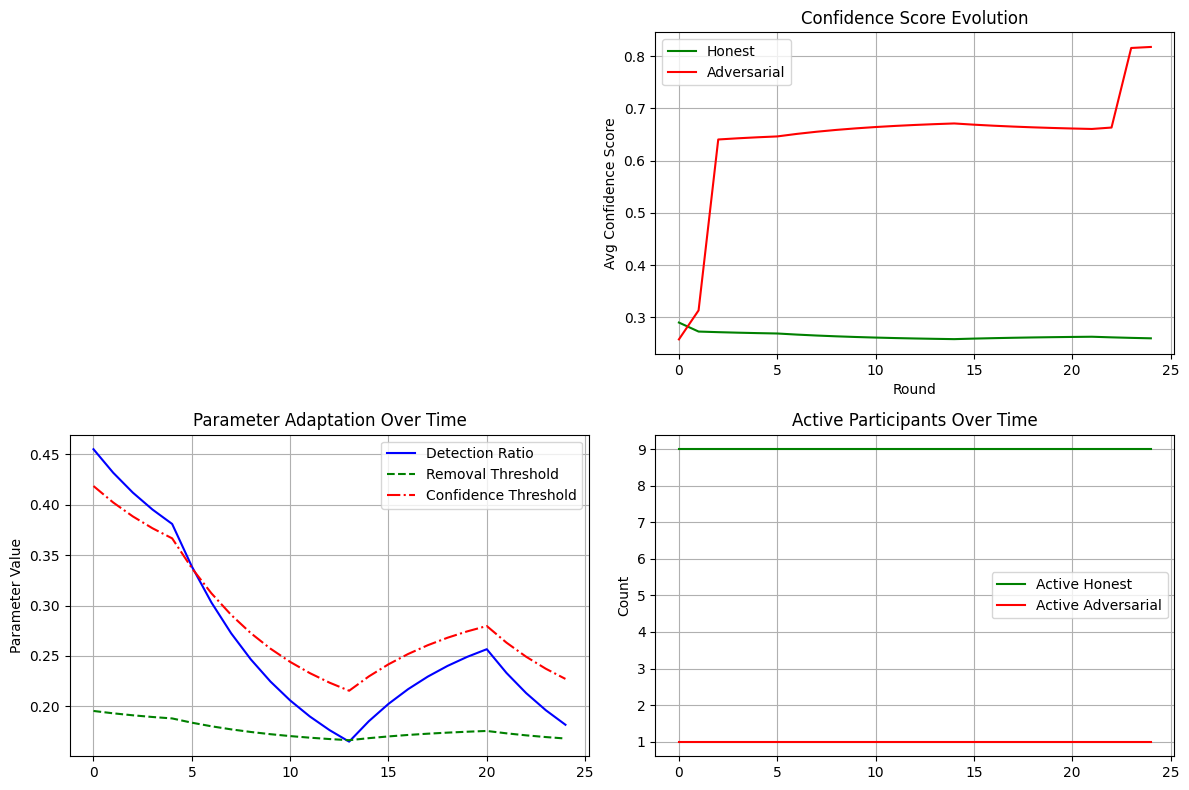

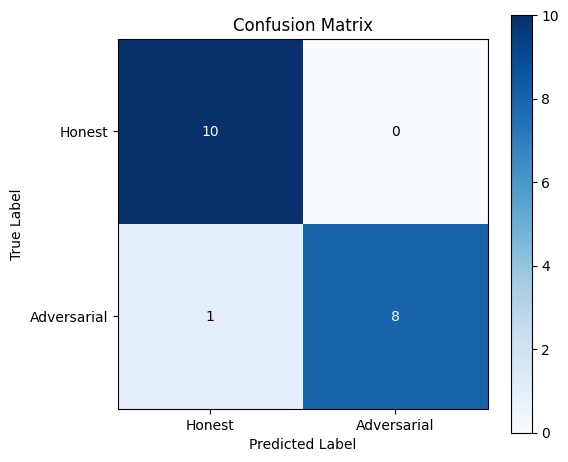


DETECTION PERFORMANCE:
--------------------------------------------------
Accuracy:      94.74%
Precision:     100.00%
Recall:        88.89%
F1 Score:      94.12%
ROC AUC:       100.00%
--------------------------------------------------
Honest Removed:       0.0% (0/10)
Adversarial Removed:  88.9% (8/9)
Removal Preference:   0.9x
--------------------------------------------------
True Positives:      8
False Positives:     0
True Negatives:     10
False Negatives:     1
--------------------------------------------------
Parameter Adaptation:
  Final Detection Ratio: 0.18
  Removal Threshold Change: -0.03
  Confidence Threshold Change: -0.19
--------------------------------------------------

PARTICIPANT BEHAVIOR ANALYSIS:
--------------------------------------------------
Average selection rate (honest):      0.000
Average selection rate (adversarial): 0.111
Selection rate gap:                   -0.111

FINAL RESULTS:
Honest participants: 10/10 remaining (0.0% removed)
Adversarial par

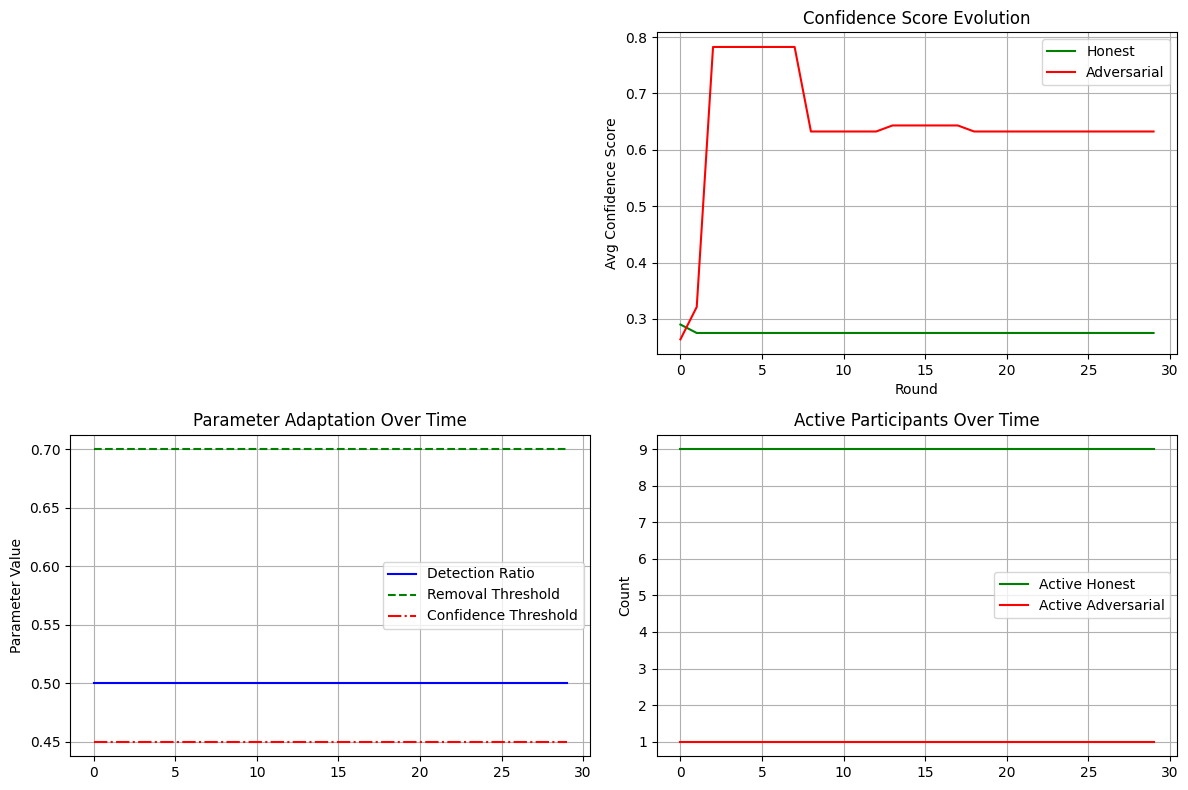

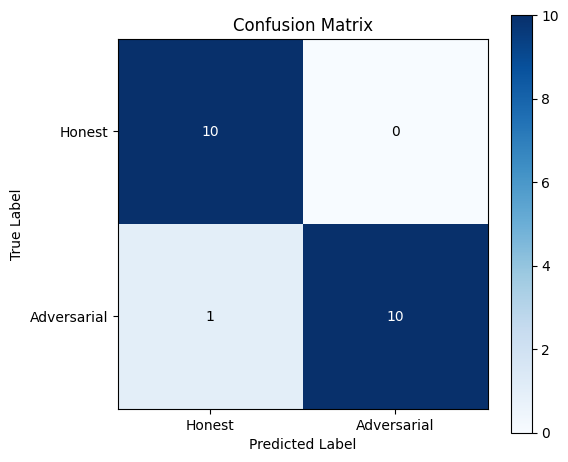


DETECTION PERFORMANCE:
--------------------------------------------------
Accuracy:      95.24%
Precision:     100.00%
Recall:        90.91%
F1 Score:      95.24%
ROC AUC:       59.09%
--------------------------------------------------
Honest Removed:       0.0% (0/10)
Adversarial Removed:  90.9% (10/11)
Removal Preference:   0.9x
--------------------------------------------------
True Positives:      10
False Positives:     0
True Negatives:     10
False Negatives:     1
--------------------------------------------------
Parameter Adaptation:
  Final Detection Ratio: 0.50
  Removal Threshold Change: 0.00
  Confidence Threshold Change: 0.00
--------------------------------------------------

PARTICIPANT BEHAVIOR ANALYSIS:
--------------------------------------------------
Average selection rate (honest):      0.000
Average selection rate (adversarial): 0.091
Selection rate gap:                   -0.091

FINAL RESULTS:
Honest participants: 10/10 remaining (0.0% removed)
Adversarial par

In [13]:
if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    device = 'cpu'
    print(f"Using device: {device}")
    dataset_path = r"C:\Users\Administrator\Desktop\v2g dataset kaggle.csv"  # Update to your path
    os.makedirs('./honest_majority_results', exist_ok=True)
    os.makedirs('./adversarial_majority_results', exist_ok=True)

    print("\n=== RUNNING HONEST MAJORITY SCENARIO ===")
    num_honest = 10
    num_adversarial = 9
    server_honest, removed_honest, metrics_honest = run_improved_v2g_simulation(
        dataset_path, num_honest, num_adversarial, rounds=25, device=device,
        adaptive_mode=True, save_dir='./honest_majority_results', no_early_stop=True
    )

    print("\n\n=== RUNNING ADVERSARIAL MAJORITY SCENARIO ===")
    num_honest = 10
    num_adversarial = 11
    server_adv, removed_adv, metrics_adv = run_improved_v2g_simulation(
        dataset_path, num_honest, num_adversarial, rounds=30, device=device,
        adaptive_mode=True, save_dir='./adversarial_majority_results', no_early_stop=True
    )

    print("\n\n=== SCENARIO COMPARISON ===")
    print("-" * 50)
    print(f"Metric | Honest Majority | Adversarial Majority")
    print("-" * 50)
    print(f"F1 Score | {metrics_honest['f1']*100:.1f}% | {metrics_adv['f1']*100:.1f}%")
    print(f"Recall | {metrics_honest['recall']*100:.1f}% | {metrics_adv['recall']*100:.1f}%")
    print(f"Adv Removed | {metrics_honest['adversarial_removal_rate']*100:.1f}% | {metrics_adv['adversarial_removal_rate']*100:.1f}%")
    print(f"Honest Removed | {metrics_honest['honest_removal_rate']*100:.1f}% | {metrics_adv['honest_removal_rate']*100:.1f}%")
    #print(f"Model Accuracy | {metrics_honest['model_accuracy']*100:.1f}% | {metrics_adv['model_accuracy']*100:.1f}%")
    print(f"Rounds | {server_honest.current_round} | {server_adv.current_round}")
    print(f"Final Detection Ratio | {metrics_honest['final_detection_ratio']:.2f} | {metrics_adv['final_detection_ratio']:.2f}")
    print("-" * 50)
